## Classification Neural Network of Twitter Accounts as Bot or Human
##### Josh Bicer 

### Summary

The objective of my model is to create an Artificial Neural Network (ANN) classification model that can accurately predict whether a Twitter user profile is a human or bot. In recent years, the prevalence of misinformation on the internet and use of targeted social media campaigns spreading false or misleading information has been at the forefront of the conversation around free speech and the internet. Twitter in particular has received a lot of attention for the company’s handling of false information. One specific method to combat this is to identify and remove “bot” accounts, or accounts that are not managed by humans and can easily post false, dangerous, or inappropriate material. The goal of this ANN model is to classify social media accounts obtained from the Twitter API as humans or bots based on the account information and usage statistics. 

The dataset used for this model was obtained from Kaggle using the dataset Bots Accounts EDA located here: https://www.kaggle.com/datasets/davidmartngutirrez/twitter-bots-accounts. The data contains about 37,000 rows which were collected from the Twitter API. The data included with each account includes the name, description, profile picture URL, number of followers, number of friends, average monthly tweets, language, location, statuses posted, and age of the account. In the dataset, roughly two-thirds are classified as real human accounts and about one-third is labeled as bot. There are 18 total feature columns and 1 label column consisting of text, numeric, date, and Boolean input values. The labels are a binary classification of “human” or “bot” to denote each account.

In [1]:
# Use code below to filter warnings
import warnings
warnings.filterwarnings('ignore')

### Import Libraries 
Import all Python libraries required for this model. This program relies on Keras package for NN model development and testing. Sklearn is used for data preprocessing and model evaluation.

In [18]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import seaborn as sn

### Load Data 
Data is loaded into a pandas data frame from a .csv file. There are several columns that will not be used in the analysis and are dropped from the model. Additionally, the data contains empty rows and values which are either imputed or dropped.

In [3]:
# Download data from Kaggle API
# !kaggle datasets download -d davidmartngutirrez/bots-accounts-eda
# !unzip twitter_human_bots_dataset.zip

# Read in data from csv files as pandas data frames
df = pd.read_csv('twitter_human_bots_dataset.csv')

# Remove index column from the dataframe
df.drop('Unnamed: 0', axis = 1, inplace = True)
# Removed unused columns from the dataframe
df.drop('description', axis = 1, inplace = True)
df.drop('id', axis = 1, inplace = True)
df.drop('profile_background_image_url', axis = 1, inplace = True)
df.drop('profile_image_url', axis = 1, inplace = True)
df.drop('created_at', axis = 1, inplace = True)

# Replace missing language rows
for i in range(len(df['lang'])):
    if pd.isnull(df['lang'][i]) == True:
        df['lang'][i] = "No Default"

# Remove rows with missing values and confirm data is complete
df.dropna(inplace = True)
df.isnull().sum()

# Convert columns to appopriate data type
df['default_profile'] = df['default_profile'].astype('boolean')
df['default_profile_image'] = df['default_profile_image'].astype('boolean')
df['geo_enabled'] = df['geo_enabled'].astype('boolean')
df['verified'] = df['verified'].astype('boolean')

# Very summary information on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37435 entries, 0 to 37437
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   default_profile         37435 non-null  boolean
 1   default_profile_image   37435 non-null  boolean
 2   favourites_count        37435 non-null  int64  
 3   followers_count         37435 non-null  int64  
 4   friends_count           37435 non-null  int64  
 5   geo_enabled             37435 non-null  boolean
 6   lang                    37435 non-null  object 
 7   location                37435 non-null  object 
 8   screen_name             37435 non-null  object 
 9   statuses_count          37435 non-null  int64  
 10  verified                37435 non-null  boolean
 11  average_tweets_per_day  37435 non-null  float64
 12  account_age_days        37435 non-null  int64  
 13  account_type            37435 non-null  object 
dtypes: boolean(4), float64(1), int64(5), o

### Data Exploration
The section below is used to gain a better understanding of the Kaggle Twitter Bots Accounts dataset through exploratory analysis and data visualizations.

In [4]:
# Summary descriptive statistics of dataset
df.describe()

,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days
count,37435.000000,3.743500e+04,3.743500e+04,3.743500e+04,37435.000000,37435.000000
mean,12300.711553,3.702306e+05,4.446267e+03,2.107434e+04,6.892042,3022.066969
std,33922.759282,2.470853e+06,4.954717e+04,6.733232e+04,24.581054,1013.708322
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,483.000000
25%,362.000000,3.500000e+01,3.700000e+01,1.336500e+03,0.495000,2316.000000
50%,2066.000000,3.650000e+02,2.960000e+02,4.209000e+03,1.488000,3219.000000
75%,8879.000000,8.437500e+03,8.930000e+02,1.715350e+04,5.528000,3888.000000
max,885123.000000,1.216415e+08,4.343060e+06,2.771910e+06,1269.055000,5158.000000


In [5]:
# Run a correlation matrix
df.corr()

,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,statuses_count,verified,average_tweets_per_day,account_age_days
default_profile,1.000000,0.116004,-0.088836,-0.089933,-0.048897,-0.273823,-0.131846,-0.264931,-0.082257,-0.459360
default_profile_image,0.116004,1.000000,-0.035905,-0.018059,-0.010600,-0.095837,-0.027593,-0.058532,-0.020463,-0.047471
favourites_count,-0.088836,-0.035905,1.000000,-0.024523,0.066209,0.135458,0.264011,0.004874,0.275585,0.024044
followers_count,-0.089933,-0.018059,-0.024523,1.000000,0.048486,0.042502,0.031299,0.273434,0.010845,0.119080
friends_count,-0.048897,-0.010600,0.066209,0.048486,1.000000,0.028228,0.077871,0.051036,0.059841,0.043841
geo_enabled,-0.273823,-0.095837,0.135458,0.042502,0.028228,1.000000,0.090182,0.196090,0.057761,0.280089
statuses_count,-0.131846,-0.027593,0.264011,0.031299,0.077871,0.090182,1.000000,0.079061,0.929172,0.115318
verified,-0.264931,-0.058532,0.004874,0.273434,0.051036,0.196090,0.079061,1.000000,0.027555,0.350256
average_tweets_per_day,-0.082257,-0.020463,0.275585,0.010845,0.059841,0.057761,0.929172,0.027555,1.000000,0.009878
account_age_days,-0.459360,-0.047471,0.024044,0.119080,0.043841,0.280089,0.115318,0.350256,0.009878,1.000000


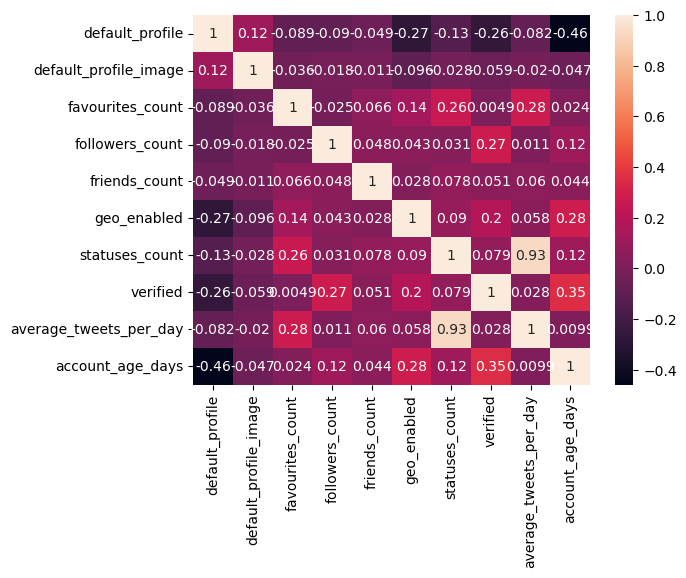

In [6]:
# Plot the correlation matrix
# It is noted that input variables average_tweets_per_day and
# statuses_count have a high positive correlation of .93
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

### Define Parameters

In [7]:
# Set variables for model parameters
num_epochs = 50
size_batch = 16
verbose_setting = 1
neurons = 10     # Number of neurons in first layer
layer2Neurons = 32     # Number of neurons in second layer


# Create lists to store model parameters
train_times = []
losses = []
metrics = []
test_loss = []
test_acc = []

### Pretreat Data
Data is provided in text, numeric, and boolean formatting and therefore requires encoding for the model to process. I use the Label Econder method below to convert the string variables to text and convert relevant categorical variables. The Standard Scaler is applied to numeric data in order remove bias of varying number scales. The to_categorical function is applied to the y variable which takes two possible responses of Bot or Human.

In [8]:
# Use Label Enocder method on non integer variables
le = LabelEncoder()

# Encode categorical variables to integer
df['default_profile'] = le.fit_transform(df['default_profile'])
df['default_profile_image'] = le.fit_transform(df['default_profile_image'])
df['geo_enabled'] = le.fit_transform(df['geo_enabled'])
df['verified'] = le.fit_transform(df['verified'])

# Encode text variables to integer
df['lang'] = le.fit_transform(df['lang'])
df['location'] = le.fit_transform(df['location'])
df['screen_name'] = le.fit_transform(df['screen_name'])

# Convert dataframes in training and testing data sets
dataset = df.values

# Extract features for x and labels for y
x = dataset[:,0:13]
y = dataset[:,13]

# Convert y variable to categorical
y = le.fit_transform(y)

# Use standard scaler preprocessor to standardize the data
scaler = preprocessing.StandardScaler()

x[:,2] = scaler.fit_transform(x[:,2].reshape(-1,1)).reshape(1,-1) # Favorites Count
x[:,3] = scaler.fit_transform(x[:,3].reshape(-1,1)).reshape(1,-1)   # Followers Count
x[:,4] = scaler.fit_transform(x[:,4].reshape(-1,1)).reshape(1,-1)   # Friends Count
x[:,9] = scaler.fit_transform(x[:,9].reshape(-1,1)).reshape(1,-1)   # Statuses Count
x[:,11] = scaler.fit_transform(x[:,11].reshape(-1,1)).reshape(1,-1)   # Avg Tweets per Day
x[:,12] = scaler.fit_transform(x[:,11].reshape(-1,1)).reshape(1,-1)   # Account Age Days

# Confirm data is shaped and formatted correctly
x = np.asarray(x).astype('float32')

# Split the data into training and testing sets with 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

### Define Model
Function below is used to define and build the model. The function takes default values but the randomized search CV method is used in the next section to identify the best possible hyperparameters. The model is defined with 2 Dense Layers, both of which contain a Dropout layer immediately after. The NN Model uses the softmax activation function in the last Dense output layer due to the nature of the classification problem.

In [9]:
# Define function to create model

def get_model(neurons = neurons, layer2Neurons = layer2Neurons, 
              dropout_rate = .2, activation = 'relu', optimizer = 'adam'):
    # Create the model with 2 Dense Hidden Layers
    model = Sequential()
    model.add(Dense(neurons, input_shape = (13, ), activation = activation))
    # Add dropout after hidden Dense layers
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation = activation))
    model.add(Dropout(dropout_rate))
    # Output Layer
    model.add(Dense(2, activation = 'softmax'))
    
    return model

### Fit Model
The model takes an average of 10 minutes to run using the parameters defined in the Randomized Search CV detailed below. Accuracy is used as the performance metric in this section. A validation data set with a 20% split is used to train the model. Results including training accuracy, testing accuracy, training time, and validation accuracy and lost are displayed in the section below. 

In [10]:
# Start the timer for run time
start_time = datetime.datetime.now()

# Set Seed
np.random.seed(1)

# Add an early stopping parameters after 10 epochs of no improvement
es = EarlyStopping(monitor = 'accuracy', verbose = verbose_setting,
                   patience = 10)

# Create the model using Keras Classifier wrapper and function above
model = KerasClassifier(build_fn = get_model, 
                        verbose = verbose_setting,
                        loss = 'sparse_categorical_crossentropy',
                        metrics = ['accuracy'])

# Define parameters to use in Randomized Search CV
neurons = [10, 20, 30, 40, 50]
dropout_rate = [.1, .3, .5, .7, .9]
batch_size = [4, 8, 16, 32, 64]
epochs = [10, 20, 30, 40, 50]
optimizer = ['RMSprop', 'Adam', 'SGD']

# Create the list of parameters to validate as a dictionary
params = dict(model__dropout_rate = dropout_rate,
                  batch_size = batch_size,
                  epochs = epochs,
                  model__optimizer = optimizer,
                  model__neurons = neurons)

# Create the randomized search optimizer
optimizer = RandomizedSearchCV(estimator = model, 
                               n_jobs = -1, 
                               cv = 3,
                               param_distributions = params,
                               scoring = 'accuracy')

# Fit the model using 80/20 validation set
# Set early stopping as the callback method
optimizerResults = optimizer.fit(x_train, 
                                 y_train, 
                                 validation_split = .2,
                                 callbacks = [es])

# Print the results of the best model found
print(f'The best score is {optimizerResults.best_score_}')
print(f'The best parameters are {optimizerResults.best_params_}')

# Calculate and print the tome to run
stop_time = datetime.datetime.now()
total_time = stop_time - start_time
print ("Time required for training:",total_time)
train_times.append(total_time)

Epoch 1/50
1498/1498 [==============================] - 2s 1ms/step - loss: 53.2160 - accuracy: 0.6161 - val_loss: 0.6372 - val_accuracy: 0.6658
Epoch 2/50
1498/1498 [==============================] - 2s 1ms/step - loss: 0.8898 - accuracy: 0.6678 - val_loss: 0.6372 - val_accuracy: 0.6658
Epoch 3/50
1498/1498 [==============================] - 2s 1ms/step - loss: 0.6993 - accuracy: 0.6686 - val_loss: 0.6372 - val_accuracy: 0.6658
Epoch 4/50
1498/1498 [==============================] - 2s 1ms/step - loss: 0.7307 - accuracy: 0.6692 - val_loss: 0.6371 - val_accuracy: 0.6658
Epoch 5/50
1498/1498 [==============================] - 2s 1ms/step - loss: 0.7131 - accuracy: 0.6690 - val_loss: 0.6372 - val_accuracy: 0.6658
Epoch 6/50
1498/1498 [==============================] - 2s 1ms/step - loss: 0.6727 - accuracy: 0.6693 - val_loss: 0.6371 - val_accuracy: 0.6658
Epoch 7/50
1498/1498 [==============================] - 2s 1ms/step - loss: 0.6919 - accuracy: 0.6689 - val_loss: 0.6372 - val_accuracy

### Show Output
Results of the model are displayed in the graphs and tables below. The graphs feature the validation and training accuracy and loss over the epochs used in training. The table displayed is a pandas dataframe with all relevant performance evaluation metrics included.

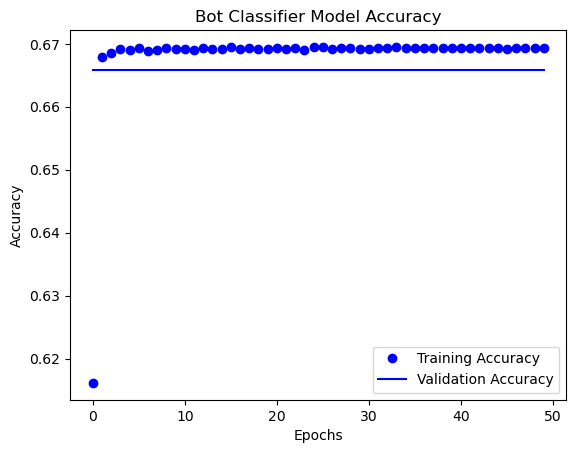

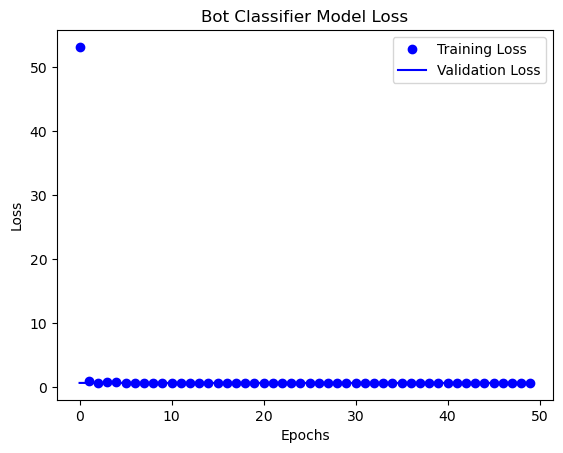

               Bot Classification Model
Train Loss                     0.648573
Train Accuracy                 0.669505
Train Time               0:15:09.050505


In [11]:
# Extract the best model performance
bestModel = optimizerResults.best_estimator_

# Extract accuracy and loss parameters from model history
loss = bestModel.history_['loss']
valLoss = bestModel.history_['val_loss']
acc = bestModel.history_['accuracy']
valAcc = bestModel.history_['val_accuracy']

# Plot bot classifier training and validation accuracy
epochs = range(0, bestModel.get_params()['epochs'])
plt.plot(epochs, acc, "bo", label = "Training Accuracy")
plt.plot(epochs, valAcc, "b", label = "Validation Accuracy")
plt.title("Bot Classifier Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Plot bot classifier training and validation loss
plt.plot(epochs, loss, "bo", label = "Training Loss")
plt.plot(epochs, valLoss, "b", label = "Validation Loss")
plt.title("Bot Classifier Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


#### Results table #####
headers = ["Bot Classification Model"]
index = ["Train Loss", "Train Accuracy", "Train Time"]

losses.append(min(loss)) 
metrics.append(max(acc))

results = pd.DataFrame(data = [losses, metrics, train_times], 
                       columns = headers,
                       index = index)
print(results)

### Evaluate Results

In [25]:
# Display results on testing data
results_test = bestModel.score(x_test, y_test)
print(f"\nThe resulting testing accuracy for bot classifier model is {results_test: .4f}\n")

# Use the best model to make prediction on training data
y_predicted_list = bestModel.predict(x_train)

y_predicted = np.array(y_predicted)

# Extract the actual and prediction to make a confusion matrix
cm = confusion_matrix(y_train, y_predicted)

# Display results for the true negative, false positive, false negative, and true positive
tn, fp, fn, tp = confusion_matrix(y_train, y_predicted).ravel()
(tn, fp, fn, tp)

468/468 [==============================] - 0s 588us/step

The resulting testing accuracy for bot classifier model is  0.6660

1872/1872 [==============================] - 1s 576us/step


(0, 9923, 0, 20025)